# Chapter 5: Author profiling as a Machine Learning task

## Step 1: Get the data

Explore the NLTK's interface to the Gutenberg project collection of texts.

In [1]:
import nltk
from nltk.corpus import gutenberg

gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

**Note**: you can use `gutenberg.sents` to access individual sentences. 

Let's select some authors and get some of their works into the training set. Some of the largest number of works in this collection are for *Jane Austen* and *William Shakespeare*, so for the rest of the chapter let's stick with those:

In [2]:
author1_train = gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')
print (author1_train)
print (len(author1_train))

[['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']'], ['VOLUME', 'I'], ...]
11499


In [3]:
author1_test = gutenberg.sents('austen-sense.txt')
print (author1_test)
print (len(author1_test))

[['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ...]
4999


In [4]:
author2_train = gutenberg.sents('shakespeare-caesar.txt') + gutenberg.sents(
    'shakespeare-hamlet.txt')
print (author2_train)
print (len(author2_train))

[['[', 'The', 'Tragedie', 'of', 'Julius', 'Caesar', 'by', 'William', 'Shakespeare', '1599', ']'], ['Actus', 'Primus', '.'], ...]
5269


In [5]:
author2_test = gutenberg.sents('shakespeare-macbeth.txt')
print (author2_test)
print (len(author2_test))

[['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', 'William', 'Shakespeare', '1603', ']'], ['Actus', 'Primus', '.'], ...]
1907


Finally, let's check if the two authors produce markedly different texts: estimate the average number of characters per word, number of words per sentence, and *diversity* of author's vocabulary – average number of times each word occurs in a text by the author:

In [6]:
def statistics(gutenberg_data):
    for work in gutenberg_data:
        num_chars = len(gutenberg.raw(work))
        num_words = len(gutenberg.words(work))
        num_sents = len(gutenberg.sents(work))
        num_vocab = len(set(w.lower() for w in gutenberg.words(work)))
        print(round(num_chars/num_words), # average word length in characters
             round(num_words/num_sents), # average sentence length in words
             round(num_words/num_vocab), # average number of times each word occurs uniquely
             work)
        
gutenberg_data = ['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt',
                 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']
statistics(gutenberg_data)

5 25 26 austen-emma.txt
5 26 17 austen-persuasion.txt
5 28 22 austen-sense.txt
4 12 9 shakespeare-caesar.txt
4 12 8 shakespeare-hamlet.txt
4 12 7 shakespeare-macbeth.txt


## Step 2: Set additional test data

To fairly test generalization behavior, let's set additional test data from within the same set of works as we are training the algorithm on. By comparing the algorithm's performance on the set of sentences coming from the same literary works to its performances on a different set of works, you will be able to tell how well the algorithm generalizes above the words it has seen in the training data.

First, put the sentences with the author labels together:

In [7]:
all_sents = [(sent, "austen") for sent in author1_train]
all_sents += [(sent, "shakespeare") for sent in author2_train]
print (f"Dataset size = {str(len(all_sents))} sentences")

Dataset size = 16768 sentences


Next, shuffle the data and split it keeping the proportion of the author-speficic data consistent across the training and the same-data testing set. Let's call the test set coming from the same data `pre-test`:

In [8]:
import random
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit

values = [author for (sent, author) in all_sents]
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
strat_train_set = []
strat_pretest_set = []
for train_index, pretest_index in split.split(all_sents, values):
    strat_train_set = [all_sents[index] for index in train_index]
    strat_pretest_set = [all_sents[index] for index in pretest_index]

Let's check that the proportions are kept the same across the two data portions:

In [9]:
def cat_proportions(data, cat):
    count = 0
    for item in data:
        if item[1]==cat:
            count += 1
    return float(count) / float(len(data))

categories = ["austen", "shakespeare"]
rows = []
rows.append(["Category", "Overall", "Stratified train", "Stratified pretest"])
for cat in categories:
    rows.append([cat, f"{cat_proportions(all_sents, cat):.6f}", 
                f"{cat_proportions(strat_train_set, cat):.6f}",
                f"{cat_proportions(strat_pretest_set, cat):.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) 
                  for i in range(0, len(row))))

 Category     Overall   Stratified train  Stratified pretest 
 austen       0.685771  0.685776          0.685748           
 shakespeare  0.314229  0.314224          0.314252           


Now also initialize the test set in the same way, by adding author labels to the sentences:

In [10]:
test_set = [(sent, "austen") for sent in author1_test]
test_set += [(sent, "shakespeare") for sent in author2_test]

rows = []
rows.append(["Category", "Overall", "Stratified train", "Stratified pretest", "Test"])
for cat in categories:
    rows.append([cat, f"{cat_proportions(all_sents, cat):.6f}", 
                f"{cat_proportions(strat_train_set, cat):.6f}",
                f"{cat_proportions(strat_pretest_set, cat):.6f}",
                f"{cat_proportions(test_set, cat):.6f}"])

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
    print(''.join(' {:{width}} '.format(row[i], width=column_widths[i]) 
                  for i in range(0, len(row))))

 Category     Overall   Stratified train  Stratified pretest  Test     
 austen       0.685771  0.685776          0.685748            0.723863 
 shakespeare  0.314229  0.314224          0.314252            0.276137 


## Step 3: Run a benchmark model

Naive Bayes model from Chapter 2 with words as features can be used as a reasonable approach to set up the benchmark result. Let's first extract the word features:

In [11]:
def get_features(text): 
    features = {}
    word_list = [word for word in text]
    for word in word_list:
        features[word] = True
    return features

train_features = [(get_features(sents), label) for (sents, label) in strat_train_set]
pretest_features = [(get_features(sents), label) for (sents, label) in strat_pretest_set]

print(len(train_features))
print(train_features[0][0])
print(train_features[100][0])

13414
{'Pol': True, '.': True}
{'And': True, 'as': True, 'to': True, 'my': True, 'father': True, ',': True, 'I': True, 'really': True, 'should': True, 'not': True, 'have': True, 'thought': True, 'that': True, 'he': True, 'who': True, 'has': True, 'kept': True, 'himself': True, 'single': True, 'so': True, 'long': True, 'for': True, 'our': True, 'sakes': True, 'need': True, 'be': True, 'suspected': True, 'now': True, '.': True}


Now train NLTK's Naive Bayes classifier on the training data and test it on the pretest data:

In [12]:
from nltk import NaiveBayesClassifier, classify

print (f"Training set size = {str(len(train_features))} sentences")
print (f"Pretest set size = {str(len(pretest_features))} sentences")
# train the classifier
classifier = NaiveBayesClassifier.train(train_features)

print (f"Accuracy on the training set = {str(classify.accuracy(classifier, train_features))}")
print (f"Accuracy on the pretest set = {str(classify.accuracy(classifier, pretest_features))}")    
# check which words are most informative for the classifier
classifier.show_most_informative_features(50)

Training set size = 13414 sentences
Pretest set size = 3354 sentences
Accuracy on the training set = 0.9786789920978083
Accuracy on the pretest set = 0.9636255217650567
Most Informative Features
                    been = True           austen : shakes =    257.7 : 1.0
                    King = True           shakes : austen =    197.1 : 1.0
                    thou = True           shakes : austen =    191.3 : 1.0
                    Lord = True           shakes : austen =     61.2 : 1.0
                    doth = True           shakes : austen =     60.4 : 1.0
                       d = True           shakes : austen =     58.9 : 1.0
                   quite = True           austen : shakes =     55.6 : 1.0
                     Tis = True           shakes : austen =     51.6 : 1.0
                     She = True           austen : shakes =     43.2 : 1.0
                   think = True           austen : shakes =     39.9 : 1.0
                    back = True           austen : shak

Compare this performance to the performance on the new test set:

In [13]:
test_features = [(get_features(sents), label) for (sents, label) in test_set]
print (f"Test set size = {str(len(test_features))} sentences")
print (f"Accuracy on the test set = {str(classify.accuracy(classifier, test_features))}")    


Test set size = 6906 sentences
Accuracy on the test set = 0.895742832319722


Let's visualize the accuracy across the three datasets with bar charts using `matplotlib`. This will help you better understand the differences in accuracy scores.

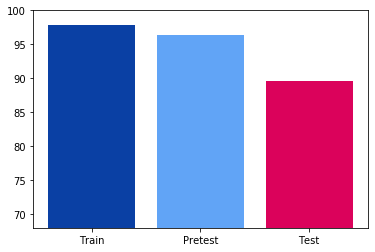

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

a = ["Train", "Pretest", "Test"]
index = range(len(a))
b = [97.87, 96.36, 89.57] # Accuracy scores for the datasets

fig, ax = plt.subplots()
axes = plt.gca()
# Let's set 68 as the lower bound as the majority class baseline is at 68.58 for the original set
axes.set_ylim([68,100])

ax.bar(index, b, color=['#0A40A4', '#61A4F6', '#DB025B'])
plt.xticks(index, a) 

plt.show()

import matplotlib
matplotlib.axes.Axes.plot
matplotlib.pyplot.plot
matplotlib.axes.Axes.legend
matplotlib.pyplot.legend


Let's apply a different classifier – `DecisionTreeClassifier` – to this task. This classifier will struggle with this high number of features (over 13K words), so let's try to narrow the number of features down. A useful heuristics is to take into account the words that are neither too frequent (e.g., occur in all or most texts) nor too rare (because they will make for very sparse and therefore not very useful features). Let's first estimate how often each word occurs across all texts, i.e. estimate their *document frequencies*:

In [15]:
from collections import Counter

words = []

def extract_words(text, words):
    words += set([word for word in text])
    return words

for (sents, label) in strat_train_set:
    words = extract_words(sents, words)

#print(len(set(words))) # =13553
counts = Counter(words)
print(len(set(counts))) # =13553
print(counts)

13553
Counter({'.': 9108, ',': 7126, 'to': 4382, 'the': 4119, 'and': 3996, 'of': 3823, 'a': 3078, 'I': 2967, 'in': 2473, 'not': 2450, ';': 2411, 'was': 2317, 'it': 2269, 'be': 2149, 'that': 1949, '"': 1932, 'you': 1884, 'her': 1877, "'": 1702, 'had': 1595, 'for': 1582, 'she': 1542, 'with': 1489, 'is': 1480, 'but': 1439, 'as': 1381, 'he': 1372, 'have': 1316, 'his': 1241, '."': 1238, 'at': 1178, 'very': 1150, 'all': 1106, 's': 1097, 'him': 1071, 'so': 1028, 'Mr': 1009, 'my': 990, 'could': 957, 'on': 904, 'would': 886, '--': 863, 'me': 856, '?': 856, ':': 853, 'been': 844, 'by': 800, 'were': 791, 'no': 785, 'this': 742, 'which': 725, 'Mrs': 716, 'She': 713, 'do': 709, 'will': 706, '-': 700, '!': 687, 'from': 677, 'must': 672, 'any': 666, 'Emma': 657, 'more': 616, 'The': 613, 'or': 610, 'them': 607, 'He': 598, 'what': 590, 'an': 590, 'are': 586, 'they': 577, 'And': 563, 'much': 561, 'there': 551, 'your': 535, 'It': 531, 'said': 530, 'one': 517, 'than': 514, ',"': 513, 'Miss': 506, 'such': 

Let's visualize how many words occur in more than a certain percentage of documents. To convert raw document counts into percentages of the total, you need to divide the number of documents in which a word occurs (in `counts`) by the total number of documents in `strat_train_set`. This total equals $13414$.

In [16]:
from numpy import arange

percentages = {}
maximum = float(13414)

# Let's explore the document frequency bands
for item in counts.items():
    perc = float(item[1])/maximum
    for freq in arange(0.00, 0.05, 0.0125):
        if perc>=freq and perc<=freq+0.0125:
            freq_range = str(freq)[:6] + "%-" + str(freq+0.0125)[:6] + "%"
            percentages[freq_range] = percentages.get(freq_range, 0) + 1
    for freq in arange(0.05, 1.00, 0.05):
        if perc>=freq and perc<=freq+0.05:
            freq_range = str(freq)[:4] + "%-" + str(freq+0.05)[:4] + "%"
            percentages[freq_range] = percentages.get(freq_range, 0) + 1

# Print out these frequency bands
for key in sorted(percentages.keys()):
    print(key + " texts: " + str(percentages.get(key)) + " words")

0.0%-0.0125% texts: 13355 words
0.0125%-0.025% texts: 84 words
0.025%-0.0375% texts: 33 words
0.0375%-0.05% texts: 22 words
0.05%-0.1% texts: 32 words
0.1%-0.15% texts: 13 words
0.15%-0.2% texts: 6 words
0.2%-0.25% texts: 2 words
0.25%-0.3% texts: 2 words
0.3%-0.35% texts: 2 words
0.5%-0.55% texts: 1 words
0.65%-0.70% texts: 1 words


Now let's visualize word document frequencies. For that, let's first arrange the word frequencies in texts in descending order and assign each word a rank: for example, the most frequent word that occurs in most texts would get a rank of 1, the second most frequent word would get a rank of 2, and so on. Next, let's plot these ranks against the total number of occurrences of each word in documents: for example, the most frequent word (full stop, ".") with rank 1 occurs in $9108$ texts, the word with rank 2 (comma, ",") occurs in $7126$ in total, and so on. Let's also select a word, for instance, "happy" and get its rank.

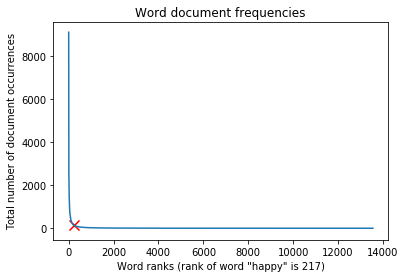

In [17]:
import operator

# Based on https://www.digitalocean.com/community/tutorials/how-to-graph-word-frequency-using-matplotlib-with-python-3
def visualize(word_doc_map, word):
    sorted_map = (sorted(word_doc_map.items(), key=operator.itemgetter(1)))[::-1]
    occurrences = []
    ranks = []
    word_rank = 0
    word_frequency = 0

    # Find the rank and overall document frequency of all words
    rank = 1
    for item in sorted_map:
        if (item[0] == word):
            word_rank = rank
            word_frequency = item[1]
        ranks.append(rank)
        rank += 1
        occurrences.append(item[1])

    # Plot word frequences against their ranks
    plt.title("Word document frequencies")
    plt.ylabel("Total number of document occurrences")
    plt.xlabel("Word ranks (rank of word \"" + word + "\" is " + str(word_rank) + ")")
    # Logarithms help present the frequency/rank information concisely
    plt.plot(ranks, occurrences)
    plt.scatter(
        [word_rank],
        [word_frequency],
        color="red",
        marker="x",
        s=100,
        label=word
    )
    plt.show()

visualize(counts, "happy")    

Frequencies drop very fast, as this graph shows. You can apply logarithmic function to the absolute frequency values to smooth the curve and make the changes in frequencies clearer:

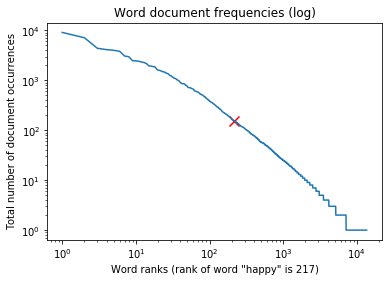

In [18]:
import operator

# Based on https://www.digitalocean.com/community/tutorials/how-to-graph-word-frequency-using-matplotlib-with-python-3
def visualize(word_doc_map, word):
    sorted_map = (sorted(word_doc_map.items(), key=operator.itemgetter(1)))[::-1]
    occurrences = []
    ranks = []
    word_rank = 0
    word_frequency = 0

    # Find the rank and overall document frequency of all words
    rank = 1
    for item in sorted_map:
        if (item[0] == word):
            word_rank = rank
            word_frequency = item[1]
        ranks.append(rank)
        rank += 1
        occurrences.append(item[1])

    # Plot word frequences against their ranks
    plt.title("Word document frequencies (log)")
    plt.ylabel("Total number of document occurrences")
    plt.xlabel("Word ranks (rank of word \"" + word + "\" is " + str(word_rank) + ")")
    # Logarithms help present the frequency/rank information concisely
    plt.loglog(ranks, occurrences, basex=10)
    plt.scatter(
        [word_rank],
        [word_frequency],
        color="red",
        marker="x",
        s=100,
        label=word
    )
    plt.show()

visualize(counts, "happy")    

These graphs exemplify *Zipf's law* – an empirical law formulated by George Kingsley Zipf, which states that the frequency of any word is inversely proportional to its rank in the frequency table. Originally, it states that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. The particular proportion is a rough estimate and depends on the data (for instance, in this case, you are looking into document rather than total word frequencies, and the ratio between the first and the second ranks is not exactly 1/2), but what matters is that the rank-frequency distribution is an inverse relation. In plain terms, this means that a small amount of very frequent words will occur in most documents, and a much larger amount of words (so-called long tail of the distribution) will be seen very rarely.

One of the problems with this distribution for clasifiers like Decision Trees is that such rare words add to the complexity of the algorithm but not help classification. Here is your first example of feature selection practices: let's filter out rare words and consider as features only the words that occur with in certain proportion or number of documents. The code below uses a minimum frequency threshold of $200$ documents for the word to be considered as a feature, and a maximum frequency threshold of $20\%$ of the texts. Feel free to modify these values.

In [19]:
from nltk import DecisionTreeClassifier

maximum = float(13414)

selected_words = []
for item in counts.items():
    count = float(item[1])
    if count > 200 and count/maximum < 0.2:
        selected_words.append(item[0])
print(len(selected_words))

def get_features(text, selected_words): 
    features = {}
    word_list = [word for word in text]
    for word in word_list:
        if word in selected_words:
            features[word] = True
    return features

train_features = [(get_features(sents, selected_words), label) for (sents, label) 
                  in strat_train_set]
pretest_features = [(get_features(sents, selected_words), label) for (sents, label) 
                    in strat_pretest_set]
test_features = [(get_features(sents, selected_words), label) for (sents, label) 
                 in test_set]


classifier = DecisionTreeClassifier.train(train_features)

print (f"Accuracy on the training set = {str(classify.accuracy(classifier, train_features))}")
print (f"Accuracy on the pretest set = {str(classify.accuracy(classifier, pretest_features))}")    
print (f"Accuracy on the test set = {str(classify.accuracy(classifier, test_features))}")    

166
Accuracy on the training set = 0.8099746533472492
Accuracy on the pretest set = 0.7960644007155635
Accuracy on the test set = 0.8066898349261512


Finally, let's visualize these accuracy scores. Note that despite the results being overall lower than those you achieved with the benchmark model, they are consistent across all three datasets, which shows that the classifier generalizes well.

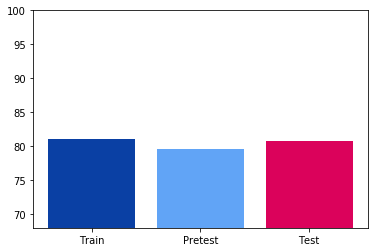

<function matplotlib.pyplot.legend(*args, **kwargs)>

In [20]:
a = ["Train", "Pretest", "Test"]
index = range(len(a))
b = [81.00, 79.64, 80.79] # Accuracy scores for the datasets

fig, ax = plt.subplots()
axes = plt.gca()
# Let's set 68 as the lower bound as the majority class baseline is at 68.58 for the original set
axes.set_ylim([68,100])

ax.bar(index, b, color=['#0A40A4', '#61A4F6', '#DB025B'])
plt.xticks(index, a) 

plt.show()

import matplotlib
matplotlib.axes.Axes.plot
matplotlib.pyplot.plot
matplotlib.axes.Axes.legend
matplotlib.pyplot.legend

# Chapter 6: Linguistic feature engineering for author profiling


## Step 4: Run a different model with a different set of features 

**Feature types 1 and 2 – simple statistics over the length of words**: Take average number of words per sentence and average number of characters per words as features:

In [21]:
#average word length in characters
def avg_number_chars(text):
    total_chars = 0.0
    for word in text:
        total_chars += len(word)
    return float(total_chars)/float(len(text))

#length in terms of words
def number_words(text):
    return float(len(text))

print(avg_number_chars(["Not", "so", "happy", ",", "yet", "much", "happyer"]))
print(number_words(["Not", "so", "happy", ",", "yet", "much", "happyer"]))

3.5714285714285716
7.0


Represent all data sets with their feature sets. You will need to initialize a feature set for each text and map it to the author. In addition, let's switch to numerical representation of author labels:

In [22]:
def initialize_dataset(source):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list=[]
        feature_list.append(avg_number_chars(sent))
        feature_list.append(number_words(sent))
        all_features.append(feature_list)
        if label=="austen": targets.append(0)
        else: targets.append(1)
    return all_features, targets

train_data, train_targets = initialize_dataset(strat_train_set)
pretest_data, pretest_targets = initialize_dataset(strat_pretest_set)
test_data, test_targets = initialize_dataset(test_set)

print (len(train_data), len(train_targets))
print (len(pretest_data), len(pretest_targets))
print (len(test_data), len(test_targets))

13414 13414
3354 3354
6906 6906


Now apply classification with the `sklearn`'s `Decision Trees` classifier:

In [23]:
from sklearn.tree import DecisionTreeClassifier

text_clf = DecisionTreeClassifier(random_state=42)
text_clf.fit(train_data, train_targets)  
predicted = text_clf.predict(pretest_data)

Run evaluation including the following metrics: *accuracy*, *confusion matrix*, *precision*, *recall* and *F1*:

In [24]:
import numpy as np
from sklearn import metrics

def evaluate(predicted, targets):
    print(np.mean(predicted == targets))
    print(metrics.confusion_matrix(targets, predicted))
    print(metrics.classification_report(targets, predicted))
    
evaluate(predicted, pretest_targets)

0.7975551580202743
[[2133  167]
 [ 512  542]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      2300
           1       0.76      0.51      0.61      1054

    accuracy                           0.80      3354
   macro avg       0.79      0.72      0.74      3354
weighted avg       0.79      0.80      0.78      3354



And on the test set:

In [25]:
predicted = text_clf.predict(test_data)
evaluate(predicted, test_targets)

0.8049522154648132
[[4605  394]
 [ 953  954]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4999
           1       0.71      0.50      0.59      1907

    accuracy                           0.80      6906
   macro avg       0.77      0.71      0.73      6906
weighted avg       0.80      0.80      0.79      6906



This looks like a much more generalizable set of features – the performance on both set is very close ($0.7973$ vs. $0.8050$). Besides, it contains only $2$ features as opposed to over $13K$ words! However, now the performance is much lower than with words. Let's try and improve it further. Let's visualize these results with `matplotlib`:

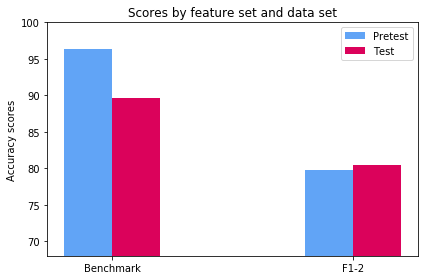

In [26]:
# Adapted from: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
pretestAcc = (96.36, 79.72)
testAcc = (89.57, 80.49)

ind = np.arange(len(pretestAcc))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, pretestAcc, width, label='Pretest', color='#61A4F6')
rects2 = ax.bar(ind + width/2, testAcc, width, label='Test', color='#DB025B')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy scores')
ax.set_ylim([68,100])
ax.set_title('Scores by feature set and data set')
ax.set_xticks(ind)
ax.set_xticklabels(('Benchmark', 'F1-2'))
ax.legend()

fig.tight_layout()

plt.show()

**Feature type 3 – count of stopwords**: Add `spaCy` functionality and see how only a handful of frequent words are distributed in texts:

In [27]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_md')

In [28]:
# a very general method that can be applied to any type of words
def word_counts(text):
    counts = {}
    for word in text:
        counts[word.lower()] = counts.get(word.lower(), 0) + 1
    return counts

Now let's augment our feature set with the counts of stopwords only:

In [29]:
def initialize_dataset(source):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list=[]
        feature_list.append(avg_number_chars(sent))
        feature_list.append(number_words(sent))
        counts = word_counts(sent)
        for word in STOP_WORDS:
            if word in counts.keys():
                feature_list.append(counts.get(word))
            else:
                feature_list.append(0)        
        all_features.append(feature_list)
        if label=="austen": targets.append(0)
        else: targets.append(1)
    return all_features, targets

train_data, train_targets = initialize_dataset(strat_train_set)
pretest_data, pretest_targets = initialize_dataset(strat_pretest_set)
test_data, test_targets = initialize_dataset(test_set)

print (len(train_data), len(train_targets))
print (len(pretest_data), len(pretest_targets))
print (len(test_data), len(test_targets))

13414 13414
3354 3354
6906 6906


Now train and test on both pretest and test data:

In [30]:
text_clf = DecisionTreeClassifier(random_state=42)
text_clf.fit(train_data, train_targets)  
predicted = text_clf.predict(pretest_data)
evaluate(predicted, pretest_targets)

predicted = text_clf.predict(test_data)
evaluate(predicted, test_targets)

0.8127608825283243
[[1967  333]
 [ 295  759]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2300
           1       0.70      0.72      0.71      1054

    accuracy                           0.81      3354
   macro avg       0.78      0.79      0.78      3354
weighted avg       0.81      0.81      0.81      3354

0.8087170576310455
[[4225  774]
 [ 547 1360]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.86      4999
           1       0.64      0.71      0.67      1907

    accuracy                           0.81      6906
   macro avg       0.76      0.78      0.77      6906
weighted avg       0.82      0.81      0.81      6906



There is a slight improvement in accuracy of about $0.005$ (or $0.5\%$), up to $0.812$-$0.815$ and $0.806$-$0.81$. However, what is most interesting about this feature is that there is now a more considerable improvement in performance metrics on the minority class (*shakespeare*): on the pretest set recall rises from $0.51$ to $0.72$ and F1 from $0.61$ to $0.71$ – a whole of $10$ points; on the test set the improvement in recall is from $0.50$ to $0.71$ and in F1 from $0.59$ to $0.67$. 

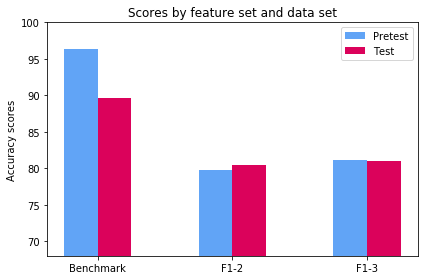

In [31]:
pretestAcc = (96.36, 79.72, 81.18) # use the last accuracy score as the last value
testAcc = (89.57, 80.49, 80.96) # use the last accuracy score as the last value

ind = np.arange(len(pretestAcc))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, pretestAcc, width, label='Pretest', color='#61A4F6')
rects2 = ax.bar(ind + width/2, testAcc, width, label='Test', color='#DB025B')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy scores')
ax.set_ylim([68,100])
ax.set_title('Scores by feature set and data set')
ax.set_xticks(ind)
ax.set_xticklabels(('Benchmark', 'F1-2', 'F1-3'))
ax.legend()

fig.tight_layout()

plt.show()

**Feature type 4 – proportion of stopwords**: Estimate what proportion of words in sentence are stopwords:

In [32]:
def proportion_words(text, wordlist):
    count = 0
    for word in text:
        if word.lower() in wordlist:
            count += 1
    return float(count)/float(len(text))

def initialize_dataset(source):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list=[]
        feature_list.append(avg_number_chars(sent))
        feature_list.append(number_words(sent))
        counts = word_counts(sent)
        for word in STOP_WORDS:
            if word in counts.keys():
                feature_list.append(counts.get(word))
            else:
                feature_list.append(0)        
        feature_list.append(proportion_words(sent, STOP_WORDS))
        all_features.append(feature_list)
        if label=="austen": targets.append(0)
        else: targets.append(1)
    return all_features, targets

train_data, train_targets = initialize_dataset(strat_train_set)
pretest_data, pretest_targets = initialize_dataset(strat_pretest_set)
test_data, test_targets = initialize_dataset(test_set)

print (len(train_data), len(train_targets))
print (len(pretest_data), len(pretest_targets))
print (len(test_data), len(test_targets))

13414 13414
3354 3354
6906 6906


As before, train and test on both pretest and test data:

In [33]:
text_clf = DecisionTreeClassifier(random_state=42)
text_clf.fit(train_data, train_targets)  
predicted = text_clf.predict(pretest_data)
evaluate(predicted, pretest_targets)

predicted = text_clf.predict(test_data)
evaluate(predicted, test_targets)

0.8106738223017292
[[1985  315]
 [ 320  734]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2300
           1       0.70      0.70      0.70      1054

    accuracy                           0.81      3354
   macro avg       0.78      0.78      0.78      3354
weighted avg       0.81      0.81      0.81      3354

0.8124818997972777
[[4275  724]
 [ 571 1336]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4999
           1       0.65      0.70      0.67      1907

    accuracy                           0.81      6906
   macro avg       0.77      0.78      0.77      6906
weighted avg       0.82      0.81      0.81      6906



We see an even further small improvement: $0.812$-$0.815$ and $0.815$-$0.819$. Moreover, performance on both pretest and test sets is very similar now. However, overall perfomance is still not as good as what you've got with words, so let's keep going. Let's plot these values, too:

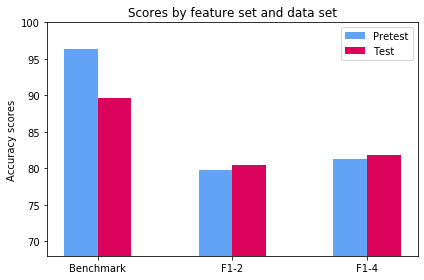

In [34]:
pretestAcc = (96.36, 79.72, 81.22) # use the last accuracy score as the last value
testAcc = (89.57, 80.49, 81.83) # use the last accuracy score as the last value

ind = np.arange(len(pretestAcc))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, pretestAcc, width, label='Pretest', color='#61A4F6')
rects2 = ax.bar(ind + width/2, testAcc, width, label='Test', color='#DB025B')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy scores')
ax.set_ylim([68,100])
ax.set_title('Scores by feature set and data set')
ax.set_xticks(ind)
ax.set_xticklabels(('Benchmark', 'F1-2', 'F1-4'))
ax.legend()

fig.tight_layout()

plt.show()

**Feature type 5 – proportion of words of specific parts of speech**: Just like you added proportion of stopwords, add proportions of words of specific parts of speech. For that, first, preprocess the sentences and for each of them keep a dictionary mapping each sentence to its `spaCy`'s representation with all language-related fields (this might take some time due to processing run by `spaCy`, so let's add some code to track how many sentences have been processed):

In [35]:
def preprocess(source):
    source_docs = {}
    index = 0
    for (sent, label) in source:
        text = " ".join(sent)
        source_docs[text] = nlp(text)
        if index>0 and (index%2000)==0:
            print(str(index) + " texts processed")
        index += 1
    print("Dataset processed")
    return source_docs

train_docs = preprocess(strat_train_set)
pretest_docs = preprocess(strat_pretest_set)
test_docs = preprocess(test_set)

2000 texts processed
4000 texts processed
6000 texts processed
8000 texts processed
10000 texts processed
12000 texts processed
Dataset processed
2000 texts processed
Dataset processed
2000 texts processed
4000 texts processed
6000 texts processed
Dataset processed


Now add the PoS distributions as features:

In [36]:
from collections import Counter
pos_list = ["C", "D", "E", "F", "I", "J", "M", "N", "P", "R", "T", "U", "V", "W"]

def pos_counts(text, source_docs, pos_list):
    pos_counts = {}
    doc = source_docs.get(" ".join(text))
    tags = []
    for word in doc:
        tags.append(str(word.tag_)[0])
    counts = Counter(tags)
    for pos in pos_list:
        if pos in counts.keys():
            pos_counts[pos] = counts.get(pos)
        else: pos_counts[pos] = 0
    return pos_counts

def initialize_dataset(source, source_docs):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list=[]
        feature_list.append(avg_number_chars(sent))
        feature_list.append(number_words(sent))
        counts = word_counts(sent)
        for word in STOP_WORDS:
            if word in counts.keys():
                feature_list.append(counts.get(word))
            else:
                feature_list.append(0)        
        feature_list.append(proportion_words(sent, STOP_WORDS))
        p_counts = pos_counts(sent, source_docs, pos_list)
        for pos in p_counts.keys():
            feature_list.append(float(p_counts.get(pos))/float(len(sent)))
        all_features.append(feature_list)
        if label=="austen": targets.append(0)
        else: targets.append(1)
    return all_features, targets

train_data, train_targets = initialize_dataset(strat_train_set, train_docs)
pretest_data, pretest_targets = initialize_dataset(strat_pretest_set, pretest_docs)
test_data, test_targets = initialize_dataset(test_set, test_docs)

print (len(train_data), len(train_targets))
print (len(pretest_data), len(pretest_targets))
print (len(test_data), len(test_targets))

13414 13414
3354 3354
6906 6906


And, as before, train, test and evaluate:

In [37]:
text_clf = DecisionTreeClassifier(random_state=42)
text_clf.fit(train_data, train_targets)  
predicted = text_clf.predict(pretest_data)
evaluate(predicted, pretest_targets)

predicted = text_clf.predict(test_data)
evaluate(predicted, test_targets)

0.8208109719737626
[[1999  301]
 [ 300  754]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2300
           1       0.71      0.72      0.72      1054

    accuracy                           0.82      3354
   macro avg       0.79      0.79      0.79      3354
weighted avg       0.82      0.82      0.82      3354

0.8284100781928757
[[4326  673]
 [ 512 1395]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4999
           1       0.67      0.73      0.70      1907

    accuracy                           0.83      6906
   macro avg       0.78      0.80      0.79      6906
weighted avg       0.83      0.83      0.83      6906



An improvement with this feature reaches $0.82$-$0.83$ on both sets.

For convenience, let's pack up the datasets initialization, training, testing and evaluation into a method, since we don't change any code in this bit:

In [38]:
def run():
    train_data, train_targets = initialize_dataset(strat_train_set, train_docs)
    pretest_data, pretest_targets = initialize_dataset(strat_pretest_set, pretest_docs)
    test_data, test_targets = initialize_dataset(test_set, test_docs)

    print (len(train_data), len(train_targets))
    print (len(pretest_data), len(pretest_targets))
    print (len(test_data), len(test_targets))
    print ()
    
    text_clf = DecisionTreeClassifier(random_state=42)
    text_clf.fit(train_data, train_targets)  
    predicted = text_clf.predict(pretest_data)
    evaluate(predicted, pretest_targets)

    predicted = text_clf.predict(test_data)
    evaluate(predicted, test_targets)
    
run()

13414 13414
3354 3354
6906 6906

0.8208109719737626
[[1999  301]
 [ 300  754]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2300
           1       0.71      0.72      0.72      1054

    accuracy                           0.82      3354
   macro avg       0.79      0.79      0.79      3354
weighted avg       0.82      0.82      0.82      3354

0.8284100781928757
[[4326  673]
 [ 512 1395]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4999
           1       0.67      0.73      0.70      1907

    accuracy                           0.83      6906
   macro avg       0.78      0.80      0.79      6906
weighted avg       0.83      0.83      0.83      6906



Let's plot the improvements in the results:

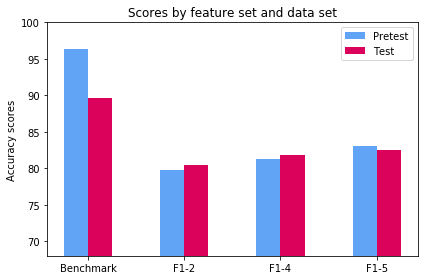

In [39]:
pretestAcc = (96.36, 79.72, 81.22, 83.10) # use the last accuracy score as the last value
testAcc = (89.57, 80.49, 81.83, 82.54) # use the last accuracy score as the last value

ind = np.arange(len(pretestAcc))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, pretestAcc, width, label='Pretest', color='#61A4F6')
rects2 = ax.bar(ind + width/2, testAcc, width, label='Test', color='#DB025B')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy scores')
ax.set_ylim([68,100])
ax.set_title('Scores by feature set and data set')
ax.set_xticks(ind)
ax.set_xticklabels(('Benchmark', 'F1-2', 'F1-4', 'F1-5'))
ax.legend()

fig.tight_layout()

plt.show()

Let's add further linguistic feature – for instance, suffixes that are already stored in the `docs`.

**Feature type 6 – count selected suffixes**: As the number of suffixes will be quite large (smaller than the number of words, though), let's set a cutoff point to, e.g. the top $40\%$ of the suffixes:

In [40]:
import operator

def select_suffixes(cutoff):
    all_suffixes = []
    for doc in train_docs.values():
        for word in doc:
            all_suffixes.append(str(word.suffix_).lower())
    counts = Counter(all_suffixes)
    sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
    selected_suffixes = []
    for i in range(0, round(len(counts)*cutoff)):
        selected_suffixes.append(sorted_counts[i][0])
    return selected_suffixes
    
selected_suffixes = select_suffixes(0.4)
print(len(selected_suffixes))
print(selected_suffixes)

577
[',', '.', 'the', 'and', 'to', 'ing', 'of', 'her', '"', 'a', 'i', 'hat', 'it', 'in', ';', 'was', 'not', 'she', 'you', 'his', 'uld', 'be', 'he', 'ere', 'had', "'", 'as', '--', 'all', 'ion', 'but', 'for', 'ith', 'ery', 'is', 'ave', 'ent', 'ill', 'nce', 'ght', 'ter', 'at', 'my', 'our', 'so', 'him', 'een', '?', 's', 'uch', 'ore', 'ome', 'mr', 'ver', 'are', 'ted', 'one', ':', 'ble', 'ell', 'no', 'on', 'now', 'any', 'ust', 'by', 'me', '!', 'hen', 'hey', 'out', 'ess', 'ich', '-', 'do', 'ure', 'mrs', 'ain', 'rom', 'elf', 'red', 'or', 'ood', 'if', 'mma', 'use', 'aid', 'hem', 'ton', 'ely', 'sed', 'own', 'est', 'man', 'an', 'ost', 'ake', 'ers', 'ear', 'nly', '_', 'we', 'iss', 'ned', 'ugh', '.--', 'lly', 'eir', 'ied', 'end', 'am', 'han', 'ons', 'did', 'ame', 'can', 'tle', 'ite', 'ose', 'ate', 'tly', 'how', 'ant', 'ard', 'ast', 'ong', 'ive', 'ity', 'who', 'ine', 'ved', 'eat', 'ect', 'iet', 'nne', 'ded', 'ink', 'way', 'ord', 'ous', 'ays', 'ime', 'ked', 'ady', 'say', 'age', 'ike', 'old', 'ies', '

In [41]:
def suffix_counts(text, source_docs, suffix_list):
    suffix_counts = {}
    doc = source_docs.get(" ".join(text))
    suffixes = []
    for word in doc:
        suffixes.append(str(word.suffix_))
    counts = Counter(suffixes)
    for suffix in suffix_list:
        if suffix in counts.keys():
            suffix_counts[suffix] = counts.get(suffix)
        else: suffix_counts[suffix] = 0
    return suffix_counts

In [42]:
def initialize_dataset(source, source_docs):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list=[]
        feature_list.append(avg_number_chars(sent))
        feature_list.append(number_words(sent))
        counts = word_counts(sent)
        for word in STOP_WORDS:
            if word in counts.keys():
                feature_list.append(counts.get(word))
            else:
                feature_list.append(0)        
        feature_list.append(proportion_words(sent, STOP_WORDS))
        p_counts = pos_counts(sent, source_docs, pos_list)
        for pos in p_counts.keys():
            feature_list.append(float(p_counts.get(pos))/float(len(sent)))
        s_counts = suffix_counts(sent, source_docs, selected_suffixes)
        for suffix in s_counts.keys():
            feature_list.append(float(s_counts.get(suffix))/float(len(sent)))
        all_features.append(feature_list)
        if label=="austen": targets.append(0)
        else: targets.append(1)
    return all_features, targets

run()

13414 13414
3354 3354
6906 6906

0.9543828264758497
[[2218   82]
 [  71  983]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2300
           1       0.92      0.93      0.93      1054

    accuracy                           0.95      3354
   macro avg       0.95      0.95      0.95      3354
weighted avg       0.95      0.95      0.95      3354

0.9501882421083117
[[4815  184]
 [ 160 1747]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4999
           1       0.90      0.92      0.91      1907

    accuracy                           0.95      6906
   macro avg       0.94      0.94      0.94      6906
weighted avg       0.95      0.95      0.95      6906



This feature brings the largest improvement: up to $0.954$-$0.956$ and $0.952$-$0.954$.

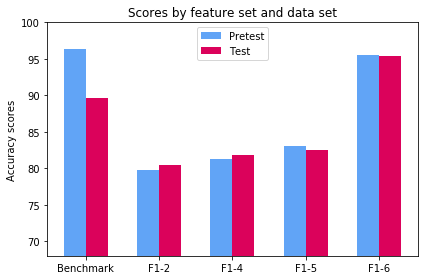

In [43]:
pretestAcc = (96.36, 79.72, 81.22, 83.10, 95.47) # use the last accuracy score as the last value
testAcc = (89.57, 80.49, 81.83, 82.54, 95.34) # use the last accuracy score as the last value

ind = np.arange(len(pretestAcc))  # the x locations for the groups
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, pretestAcc, width, label='Pretest', color='#61A4F6')
rects2 = ax.bar(ind + width/2, testAcc, width, label='Test', color='#DB025B')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy scores')
ax.set_ylim([68,100])
ax.set_title('Scores by feature set and data set')
ax.set_xticks(ind)
ax.set_xticklabels(('Benchmark', 'F1-2', 'F1-4', 'F1-5', 'F1-6'))
ax.legend()

fig.tight_layout()

plt.show()

Finally, let's collect specific (non-overlapping) vocabularies per each author.

**Feature type 7 – count words that are specific for each author**: First collect the set of words that is unique for each author (i.e., the words that only Shakespeare or only Austen uses) and then count their occurrences across the data sets. You can introduce a cutoff as before and only use, e.g., top $50\%$ of the words:

In [44]:
def unique_vocabulary(label1, label2, cutoff):
    voc1 = []
    voc2 = []
    for (sent, label) in strat_train_set:
        if label==label1:
            for word in sent:
                voc1.append(word.lower())
        elif label==label2:
            for word in sent:
                voc2.append(word.lower())    
    counts1 = Counter(voc1)
    sorted_counts1 = sorted(counts1.items(), key=operator.itemgetter(1), reverse=True)
    counts2 = Counter(voc2)
    sorted_counts2 = sorted(counts2.items(), key=operator.itemgetter(1), reverse=True)
    unique_voc = []
    for i in range(0, round(len(sorted_counts1)*cutoff)):
        if not sorted_counts1[i][0] in counts2.keys():
            unique_voc.append(sorted_counts1[i][0])
    for i in range(0, round(len(sorted_counts2)*cutoff)):
        if not sorted_counts2[i][0] in counts1.keys():
            unique_voc.append(sorted_counts2[i][0])
    return unique_voc
    
unique_voc = unique_vocabulary("austen", "shakespeare", 0.5)
print(len(unique_voc))
print(unique_voc)

4435
['"', 'have', '--', '."', 'mr', 'mrs', 'emma', 'miss', 'than', '.--', ',"', 'only', 'every', 'never', 'harriet', 'anne', 'herself', 'own', 'weston', 'knightley', 'elton', 'again', 'always', 'soon', '!--', '?"', 'captain', 'jane', 'woodhouse', 'dear', 'elliot', 'ever', 'up', 'just', 'having', 'give', 'himself', 'fairfax', 'over', 'upon', 'seemed', 'wentworth', '!"', 'churchill', 'however', '?--', 'even', 'felt', 'really', 'frank', 'us', 'its', 'room', 'half', 'feelings', 'hartfield', 'certainly', 'charles', 'smith', 'bates', 'russell', 'believe', 'love', 'family', 'evening', 'feel', 'walter', ';--', 'hear', 'looked', 'idea', 'deal', 'acquaintance', 'myself', 'highbury', 'down', 'between', 'musgrove', 'mary', 'hour', 'subject', '`', 'louisa', 'perfectly', 'suppose', 'under', 'general', 'obliged', 'happiness', 'able', 'wanted', 'replied', 'given', 'john', 'talked', 'passed', 'elizabeth', '--"', 'understand', 'nobody', 'leave', 'kind', 'less', 'interest', 'near', 'attention', 'situati

In [45]:
def unique_counts(text, unique_voc):
    unique_counts = {}
    words = []
    for word in text:
        words.append(word.lower())
    counts = Counter(words)
    for word in unique_voc:
        if word in counts.keys():
            unique_counts[word] = counts.get(word)
        else: unique_counts[word] = 0
    return unique_counts

In [46]:
def initialize_dataset(source, source_docs):
    all_features = []
    targets = []
    for (sent, label) in source:
        feature_list=[]
        feature_list.append(avg_number_chars(sent))
        feature_list.append(number_words(sent))
        counts = word_counts(sent)
        for word in STOP_WORDS:
            if word in counts.keys():
                feature_list.append(counts.get(word))
            else:
                feature_list.append(0)        
        feature_list.append(proportion_words(sent, STOP_WORDS))
        p_counts = pos_counts(sent, source_docs, pos_list)
        for pos in p_counts.keys():
            feature_list.append(float(p_counts.get(pos))/float(len(sent)))
        s_counts = suffix_counts(sent, source_docs, selected_suffixes)
        for suffix in s_counts.keys():
            feature_list.append(float(s_counts.get(suffix))/float(len(sent)))
        u_counts = unique_counts(sent, unique_voc)
        for word in u_counts.keys():
            feature_list.append(u_counts.get(word))
        all_features.append(feature_list)
        if label=="austen": targets.append(0)
        else: targets.append(1)
    return all_features, targets

run()

13414 13414
3354 3354
6906 6906

0.9633273703041145
[[2237   63]
 [  60  994]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2300
           1       0.94      0.94      0.94      1054

    accuracy                           0.96      3354
   macro avg       0.96      0.96      0.96      3354
weighted avg       0.96      0.96      0.96      3354

0.9643788010425717
[[4881  118]
 [ 128 1779]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4999
           1       0.94      0.93      0.94      1907

    accuracy                           0.96      6906
   macro avg       0.96      0.95      0.96      6906
weighted avg       0.96      0.96      0.96      6906



Our final and best result: $0.95$-$0.96$ on the pretest and $0.95$-$96$ on the test set – i.e., almost identical! What is more, the performance on both classes, majority as well as minority, is now also almost identical – F1 of $0.97$ and $0.94$ on pretest, and $0.97$ and $0.92$ on the test set.

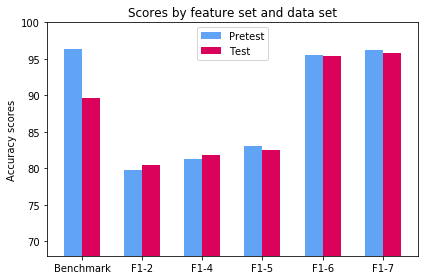

In [47]:
# use the last accuracy score as the last value
pretestAcc = (96.36, 79.72, 81.22, 83.10, 95.47, 96.27)
# use the last accuracy score as the last value
testAcc = (89.57, 80.49, 81.83, 82.54, 95.34, 95.82)

ind = np.arange(len(pretestAcc))  # the x locations for the groups
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, pretestAcc, width, label='Pretest', color='#61A4F6')
rects2 = ax.bar(ind + width/2, testAcc, width, label='Test', color='#DB025B')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy scores')
ax.set_ylim([68,100])
ax.set_title('Scores by feature set and data set')
ax.set_xticks(ind)
ax.set_xticklabels(('Benchmark', 'F1-2', 'F1-4', 'F1-5', 'F1-6', 'F1-7'))
ax.legend()

fig.tight_layout()

plt.show()